# **CANADIAN HOURLY WAGE PREDICTION USING CATBOOST**

**Objective:** This notebook documents the development of a regression model designed to estimate hourly wages using post-pandemic (2022+) Statistics Canada Labour Force Survey data. The analysis utilizes the Public Use Microdata File (PUMF), prioritizing this specific period to ensure the model reflects current labor market conditions while avoiding the economic volatility of the pandemic.

**Deployment:** A simplified version of the model is deployed via FastAPI on the Render cloud platform. This implementation allows users to interface with the model through a web API, inputting demographic and geographic variables to receive real-time wage prediction

## Data Cleaning 

Our first step is to load the dataset and retain only the relevant columns. As the hourly wage variable (HRLYEARN, with two assumed decimal places) is exclusively available for employees, we must filter the dataset to include only those records. Specifically, we exclude any rows where the Class of Worker (COWMAIN) is not identified as Public sector employees (1) or Private sector employees (2).

Additionally, we remove columns that are irrelevant to the employee population. These fields contain information collected only for other labor force statuses and consist entirely of "Not applicable" values for the employee records targeted in this model.

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
from fairlearn.metrics import MetricFrame
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error


directory_path = 'data/'
files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f)) and not f.startswith(".")]

df_all = []
for file in files:
    df = pd.read_csv(os.path.join(directory_path,file))
    df_all.append(df)
    
df = pd.concat(df_all, ignore_index=True)

#Removing IDs, survey weights, columns only related to unemployment, and clearly redundant columns 
to_remove = ['REC_NUM','EVERWORK','FTPTLAST', 'DURUNEMP', 'FLOWUNEM', 'UNEMFTPT', 'WHYLEFTO', 
             'WHYLEFTN','DURJLESS', 'AVAILABL', 'LKPUBAG', 'LKEMPLOY', 'LKRELS', 
             'LKATADS', 'LKANSADS', 'LKOTHERN', 'PRIORACT', 'YNOLOOK', 'TLOLOOK', 'NOC_10', 'AGE_6',
             'FINALWT', 'FIRMSIZE', 'PREVTEN']
df.drop(columns = to_remove, axis = 1, inplace = True)

#ONLY KEEPING CURRENT EMPLOYEES
df = df[df['LFSSTAT'].isin([1,2])]
df = df[df['COWMAIN'].isin([1,2])]
df = df.drop_duplicates()

Since missing values (item non-response) are imputed by Statistics Canada, any missing values detected during processing are treated as distinct categories. These instances indicate that the specific value was extraneous to the respondent's situation, rather than simply missing data.

A preliminary analysis identifies several variables with missing value rates exceeding 80%. Additionally, certain categorical variables (as identified in the metadata) were initially read as numeric types. To address this, we convert these categorical variables to strings and explicitly label missing values as "Not applicable." At this stage, we will retain all variables, including those with a high proportion of missing values, to preserve potential predictive features for the initial model iterations.

In [2]:
desc = pd.DataFrame(index = list(df))
desc['type'] = df.dtypes
desc['count'] = df.count()
desc['nunique'] = df.nunique()
desc['%unique'] = desc['nunique'] /len(df) * 100
desc['null'] = df.isnull().sum()
desc['%null'] = desc['null'] / len(df) * 100
#desc = pd.concat([desc,df.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(axis=0)
desc

,type,count,nunique,%unique,null,%null
SURVYEAR,int64,2654161,4,0.000151,0,0.000000
SURVMNTH,int64,2654161,12,0.000452,0,0.000000
LFSSTAT,int64,2654161,2,0.000075,0,0.000000
PROV,int64,2654161,10,0.000377,0,0.000000
CMA,int64,2654161,10,0.000377,0,0.000000
AGE_12,int64,2654161,12,0.000452,0,0.000000
GENDER,int64,2654161,2,0.000075,0,0.000000
MARSTAT,int64,2654161,6,0.000226,0,0.000000
EDUC,int64,2654161,7,0.000264,0,0.000000
MJH,float64,2654161,2,0.000075,0,0.000000


In [3]:
cat_features = ['SURVMNTH','LFSSTAT','PROV','CMA','AGE_12', 'GENDER', 'MARSTAT', 'EDUC', 'MJH', 'COWMAIN', 'NAICS_21',
                'NOC_43', 'FTPTMAIN', 'YABSENT', 'PAYAWAY', 'YAWAY', 'UNION', 'WHYPT', 'IMMIG',
                 'PERMTEMP', 'ESTSIZE', 'SCHOOLN', 'EFAMTYPE', 'AGYOWNK']
temp = df[cat_features]
temp = temp.fillna(-1).astype("int64").astype("str").replace('-1', 'NotApplicable')

data = pd.concat([df.drop(columns=cat_features).reset_index(drop=True), temp.reset_index(drop=True)], axis=1)

## Explanatory Data Analysis

We perform the data split prior to conducting Exploratory Data Analysis (EDA) to prevent data leakage. This ensures that any insights or statistical patterns discovered during exploration are derived solely from the training set, maintaining the integrity of the model's evaluation on unseen data.

In [4]:
data_train, data_test = train_test_split(data, random_state=0, test_size=0.20, stratify=data['PROV'])

**Distribution Analysis**

As expected, the hourly wage distribution exhibits a significant right-skew, with values reaching up to 250.00 per hour. To manage these extremes, we first identify and remove outliers using the Interquartile Range (IQR) method. Specifically, we exclude data points falling outside the bounds defined by 1.5×IQR above the third quartile or below the first quartile.

Following this cleaning step, we apply a logarithmic transformation to the remaining data. This process reduces the skewness of the long right tail, ensuring that the model is not disproportionately influenced by high-wage variance and improving its ability to generalize across the majority of the population.

To maintain consistency in our model development, this outlier removal process and the subsequent logarithmic transformation are applied identically to both the training and testing sets. 

Text(0.5, 1.0, 'Distribution of Hourly Wage')

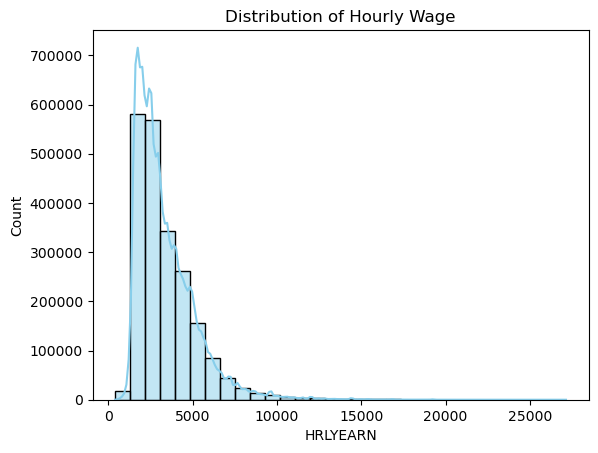

In [5]:
#Distribution of hourly wage
sns.histplot(data_train['HRLYEARN'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Hourly Wage")

In [6]:
#Removing outliers - Train set
Q1 = data_train['HRLYEARN'].quantile(0.25)
Q3 = data_train['HRLYEARN'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_mask = (data_train['HRLYEARN'] < lower_bound) | (data_train['HRLYEARN'] > upper_bound)

data_train_clean = data_train[~outliers_mask]
# Apply log transformation to the target variable
data_train_clean['HRLYEARN_LOG'] = np.log1p(data_train_clean['HRLYEARN'])

#Removing outliers - Train set
Q1 = data_test['HRLYEARN'].quantile(0.25)
Q3 = data_test['HRLYEARN'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_mask = (data_test['HRLYEARN'] < lower_bound) | (data_test['HRLYEARN'] > upper_bound)

data_test_clean = data_test[~outliers_mask]
# Apply log transformation to the target variable
data_test_clean['HRLYEARN_LOG'] = np.log1p(data_test_clean['HRLYEARN'])

/var/folders/n2/vww2b8xs3x58t098t1sv0bf00000gn/T/ipykernel_50555/96936920.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_clean['HRLYEARN_LOG'] = np.log1p(data_train_clean['HRLYEARN'])
/var/folders/n2/vww2b8xs3x58t098t1sv0bf00000gn/T/ipykernel_50555/96936920.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_clean['HRLYEARN_LOG'] = np.log1p(data_test_clean['HRLYEARN'])


Upon examining the distribution of the numerical variables, several features exhibited an extreme volume of outliers. Including these variables would introduce significant noise and potentially bias the regression results. Consequently, these specific features were removed from the model development process.


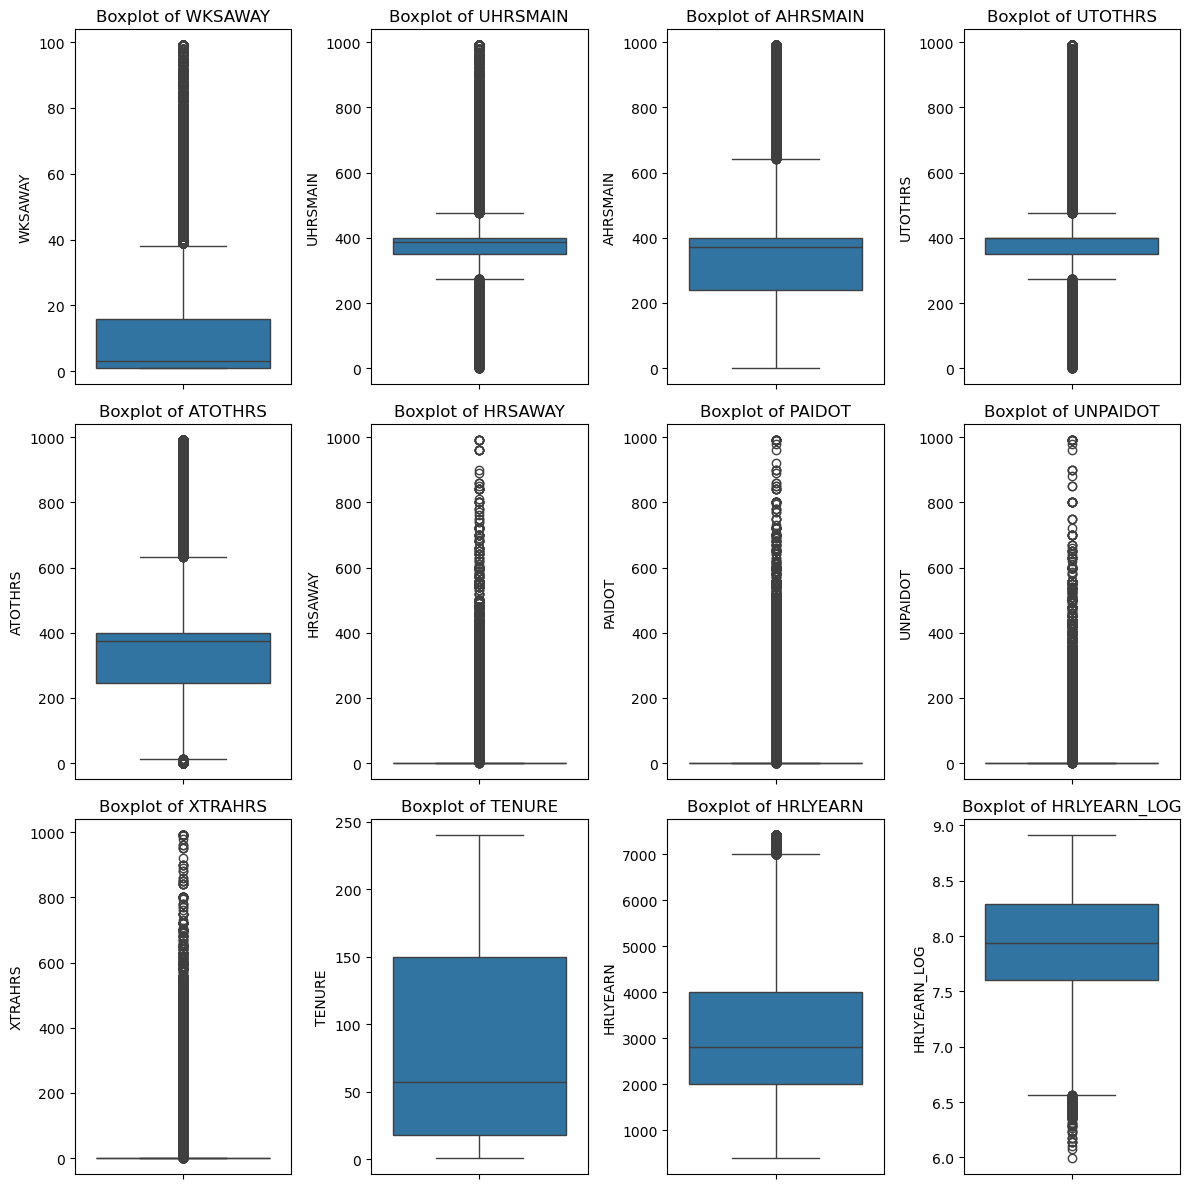

In [7]:
numeric_features = data_train_clean.columns.drop(cat_features).drop('SURVYEAR')
num_cols = numeric_features
n_cols = 4 
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    toplot = data_train_clean[col]
    sns.boxplot(data=toplot, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Hiding any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

All categorical features are retained for the initial model development.

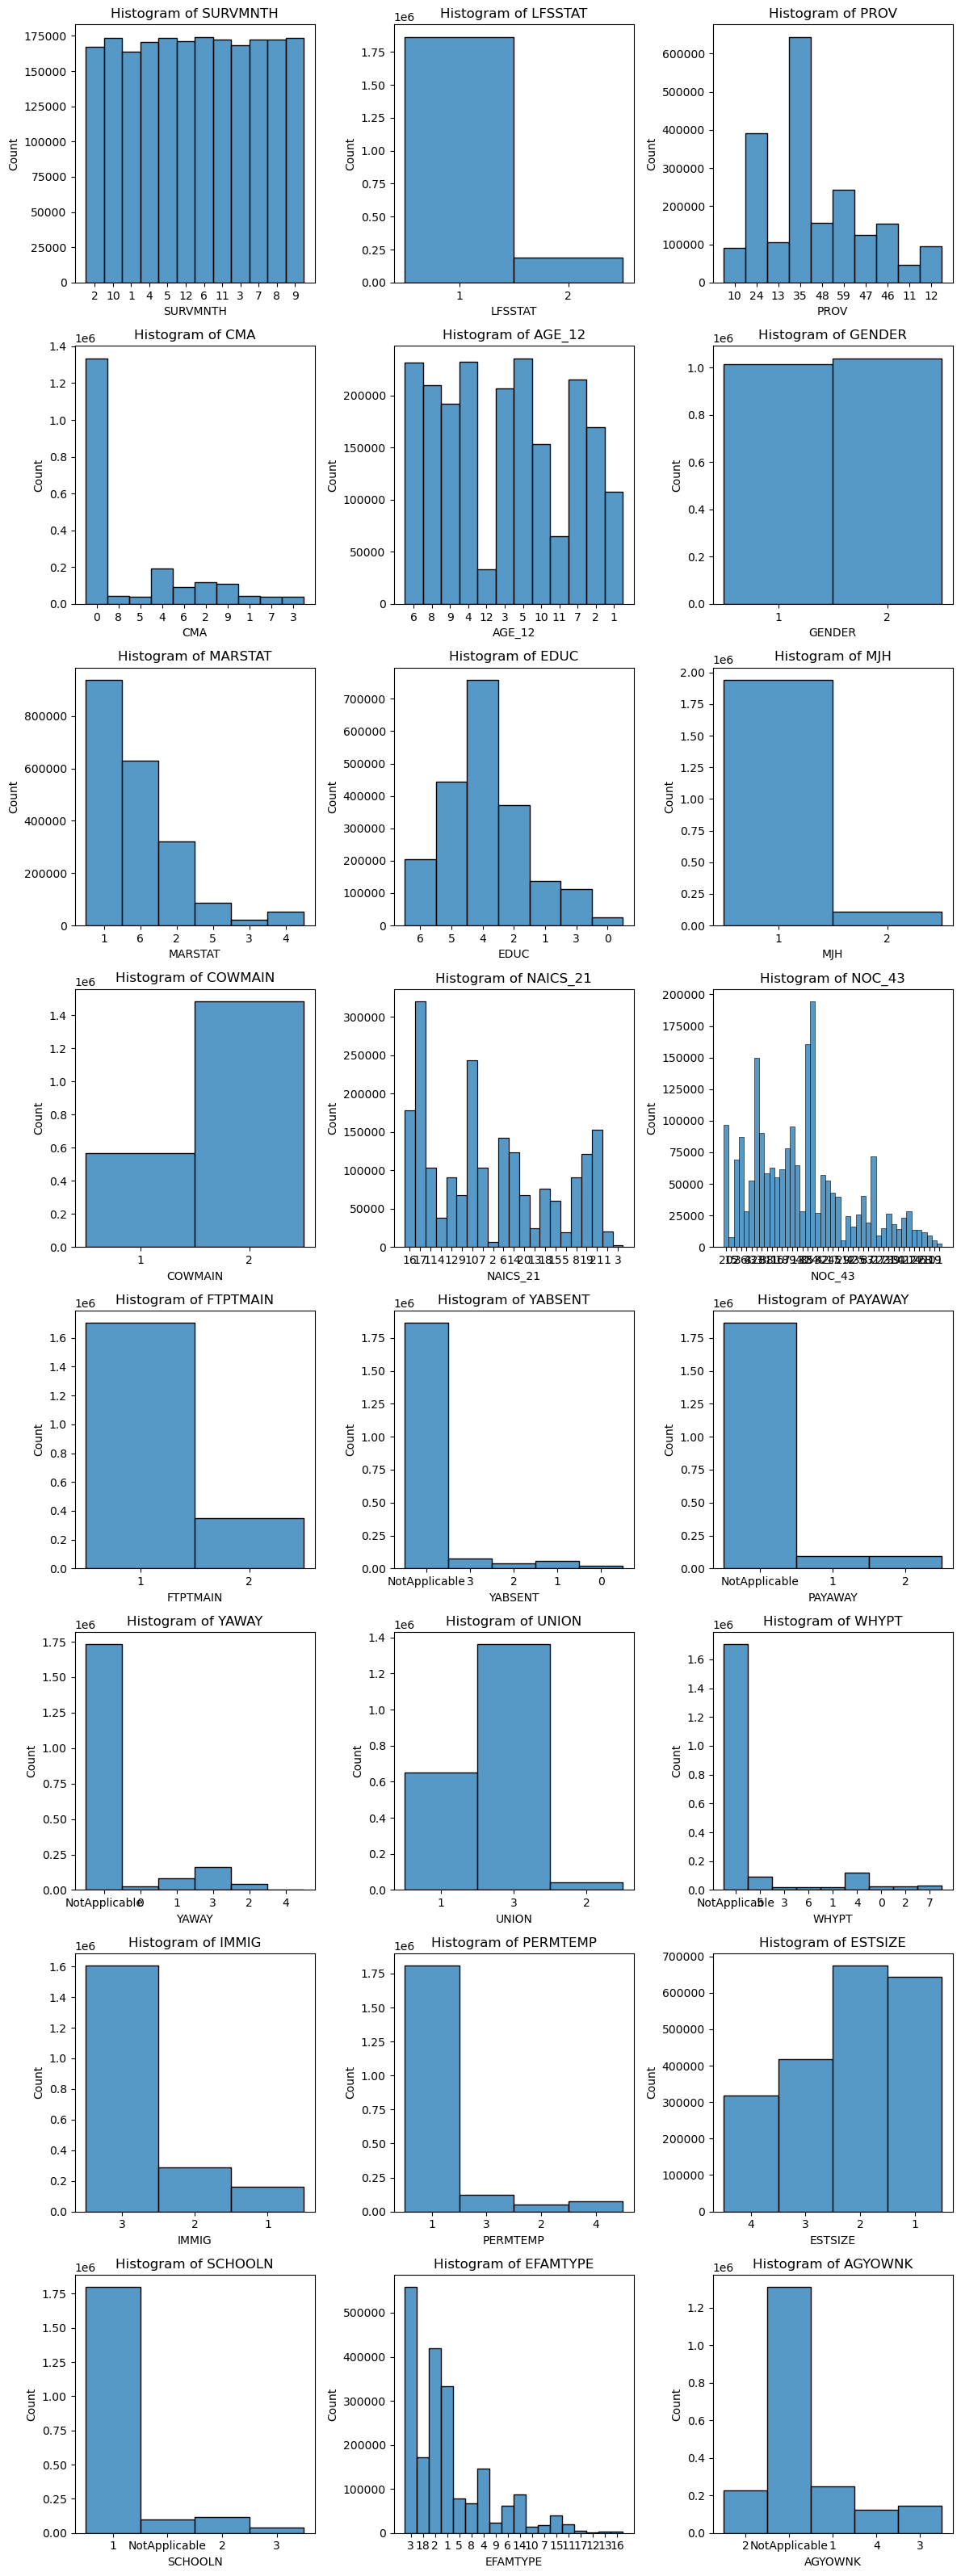

In [8]:
num_cols = cat_features
n_cols = 3  # number of plots per row
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data_train_clean.astype(str)[col], ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Final train and test sets**

In [9]:
x_train = data_train_clean.drop(columns=['HRLYEARN','HRLYEARN_LOG', 'HRSAWAY', 'PAIDOT', 'UNPAIDOT', 'XTRAHRS'])
x_test = data_test_clean.drop(columns=['HRLYEARN', 'HRLYEARN_LOG', 'HRSAWAY', 'PAIDOT', 'UNPAIDOT', 'XTRAHRS'])
y_train = data_train_clean['HRLYEARN_LOG']
y_test = data_test_clean['HRLYEARN_LOG']

## Model Training

Model Selection: CatBoost

Given the high volume of categorical variables in the Labour Force Survey data, we have selected CatBoost as the primary regression algorithm. CatBoost is specifically designed to handle categorical data eliminating the need for extensive manual preprocessing, such as One-Hot Encoding.

To ensure the final deployment remains user-friendly while maintaining high predictive accuracy, we first train an initial model to identify the most significant drivers of hourly wages. By isolating the 10 most important features, we can streamline the user input process in the FastAPI interface, requiring only the most impactful information rather than the entire survey feature set.


In [10]:
#Evaluation metric
def regression_report(y_true, y_pred):
    mse = round(mean_squared_error(y_true, y_pred), 3)
    rmse = round(np.sqrt(mse),3)
    mae = round(mean_absolute_error(y_true, y_pred),3)
    medae = round(median_absolute_error(y_true, y_pred),3)
    r2 = round(r2_score(y_true, y_pred), 3)

    report = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "MedianAE", "R2"],
        "Value": [mae, mse, rmse, medae, r2]
    })
    
    return report

In [11]:
model = CatBoostRegressor(
    iterations=20000,           
    learning_rate=0.1,  
    subsample=0.2,
    loss_function="RMSE",
    early_stopping_rounds=50,       
    verbose=False
)

model.fit(
    x_train, 
    y_train, 
    cat_features=cat_features,
    eval_set=(x_test, y_test)
)

test = Pool(x_test, cat_features=cat_features)
y_pred = model.predict(test)

report = regression_report(y_test, y_pred)
print(report)

     Metric  Value
0       MAE  0.161
1       MSE  0.048
2      RMSE  0.219
3  MedianAE  0.119
4        R2  0.735


In [17]:
report = regression_report(np.expm1(y_test), np.expm1(y_pred))
print(report)

     Metric       Value
0       MAE     517.770
1       MSE  577277.141
2      RMSE     759.788
3  MedianAE     335.351
4        R2       0.697


### Important Features

We analyze the intersection of the top features identified by both Feature Importance (CatBoost's native ranking) and SHAP (SHapley Additive exPlanations) values. By selecting the features common to both methods, we ensure that the variables we prioritize are not only statistically significant but also have a consistent directional impact on wage predictions.

Both methodologies reached a consensus on the top 10 most influential features: 'NOC_43', 'NAICS_21', 'EDUC', 'TENURE', 'ESTSIZE', 'GENDER', 'AGE_12', 'PROV', 'UNION', 'UHRSMAIN'

In [19]:
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(model)
 
# Calculate SHAP values for our test set
shap_values = explainer.shap_values(x_test)
 
print(f"SHAP values calculated for {shap_values.shape[0]} predictions")
print(f"Each prediction explained by {shap_values.shape[1]} features")
 
# The base value (expected value) - what the model predicts on "average"
print(f"Model's base prediction (expected value): ${np.expm1(explainer.expected_value):,.2f}")
 
# Quick verification: SHAP values should be additive
sample_idx = 0
model_pred = model.predict(x_test.iloc[[sample_idx]])[0]
shap_sum = explainer.expected_value + np.sum(shap_values[sample_idx])
print(f"Verification - Model prediction: ${np.expm1(model_pred):,.2f}")
print(f"Verification - SHAP sum: ${np.expm1(shap_sum)2f} ( difference:{abs(np.expm1(model_pred) - np.expm1(shap_sum)):.5f})")


SHAP values calculated for 513252 predictions
Each prediction explained by 31 features
Model's base prediction (expected value): $7.97
Verification - Model prediction: $3,615.55
Verification - SHAP sum: $8.19 ( difference:0.00000)


Our SHAP values are mathematically consistent.

In [20]:
print("Feature Importance Comparison:")
# SHAP-based importance (mean absolute SHAP values)
shap_importance = np.mean(np.abs(shap_values), axis=0)
shap_ranking = pd.DataFrame({
    'Feature': x_test.columns,
    'SHAP_Importance': shap_importance
}).sort_values('SHAP_Importance', ascending=False)
 
# Traditional XGBoost feature importance
importance = model.feature_importances_
cat_ranking = pd.DataFrame({
    'Feature': x_test.columns,
    'Catboost_Importance': importance
}).sort_values('Catboost_Importance', ascending=False)
 
print("Top 10 Most Important Features (SHAP vs CatBoost):")
print("SHAP Ranking\t\t\tCatBoost Ranking")
print("-" * 60)
for i in range(10):
    shap_feat = shap_ranking.iloc[i]['Feature'][:15]
    cat_feat = cat_ranking.iloc[i]['Feature'][:15]
    print(f"{i+1:2d}. {shap_feat:15s}\t\t{i+1:2d}. {cat_feat}")
 
print(f"\nKey Insights:")
print(f"Most impactful feature: {shap_ranking.iloc[0]['Feature']}")
print(f"Average SHAP impact per feature: ${np.mean(shap_importance):,.0f}")

Feature Importance Comparison:
Top 10 Most Important Features (SHAP vs CatBoost):
SHAP Ranking			CatBoost Ranking
------------------------------------------------------------
 1. NOC_43         		 1. NOC_43
 2. TENURE         		 2. NAICS_21
 3. NAICS_21       		 3. AGE_12
 4. SURVYEAR       		 4. TENURE
 5. ESTSIZE        		 5. PROV
 6. EDUC           		 6. ESTSIZE
 7. AGE_12         		 7. EDUC
 8. PROV           		 8. UNION
 9. GENDER         		 9. UHRSMAIN
10. UNION          		10. SURVYEAR

Key Insights:
Most impactful feature: NOC_43
Average SHAP impact per feature: $0


### Final model

In [22]:
top_features = ['NOC_43', 'NAICS_21', 'EDUC', 'TENURE', 'ESTSIZE', 'GENDER', 'AGE_12', 'PROV', 'UNION', 'UHRSMAIN']
model_simple = CatBoostRegressor(
    loss_function="RMSE",
    iterations=30000,
    early_stopping_rounds=50,
    random_seed=99,
    verbose = False
)
model_simple.fit(
    x_train[top_features], 
    y_train, 
    cat_features=['NOC_43', 'NAICS_21', 'EDUC', 'ESTSIZE', 'GENDER', 'AGE_12', 'PROV', 'UNION'],
    eval_set=(x_test[top_features], y_test),
)

test_simple = Pool(x_test[top_features], cat_features=['NOC_43', 'NAICS_21', 'EDUC', 'ESTSIZE', 'GENDER', 'AGE_12', 'PROV', 'UNION'])
y_pred_simple = model_simple.predict(test_simple)

report = regression_report(y_test, y_pred_simple)
print(report)


     Metric  Value
0       MAE  0.174
1       MSE  0.055
2      RMSE  0.235
3  MedianAE  0.131
4        R2  0.696


In [23]:
report = regression_report(np.expm1(y_test), np.expm1(y_pred_simple))
print(report)

     Metric       Value
0       MAE     557.859
1       MSE  652829.636
2      RMSE     807.979
3  MedianAE     367.479
4        R2       0.658


### Errors Analysis

The model is good at capturing the general trend and on average predicts values close to the observed data, but it struggles to predict extreme outliers. It exhibits heteroscedasticity and shows a systematic bias: it consistently overestimates lower wages and underestimates higher wages

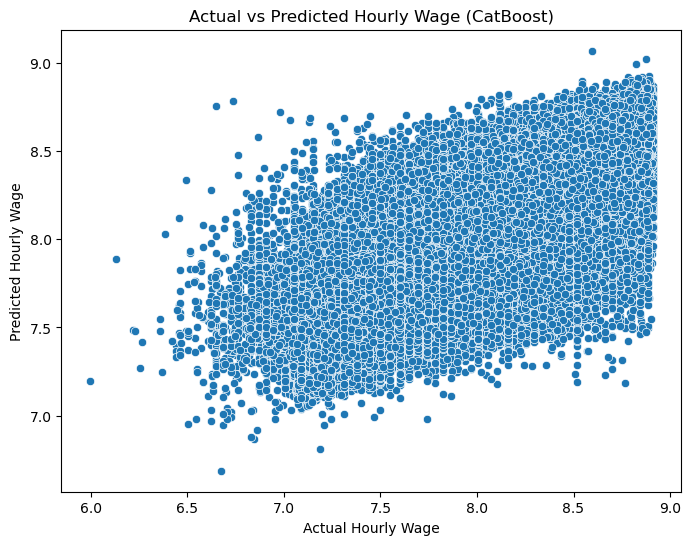

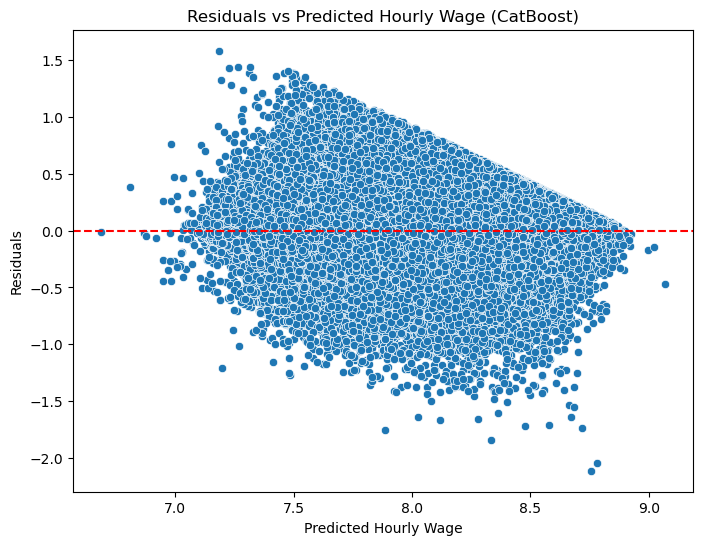

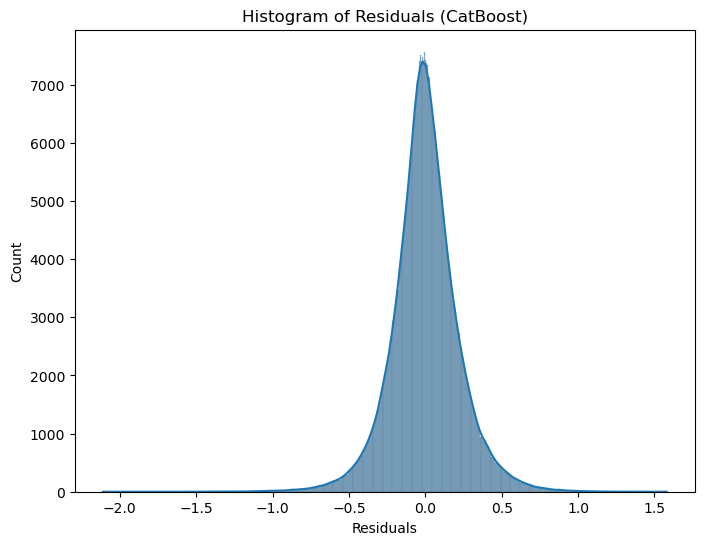

In [24]:

# Scatter plot of predicted vs actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Hourly Wage')
plt.ylabel('Predicted Hourly Wage')
plt.title('Actual vs Predicted Hourly Wage (CatBoost)')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Hourly Wage')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Hourly Wage (CatBoost)')
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals (CatBoost)')
plt.show()


### Fairness Evaluation

To determine whether the model provides equitable predictions across different demographic and geographic groups, we conducted a fairness assessment using the Fairlearn library. This allowed us to pinpoint which groups the model might be penalizing through higher error rates.

Our analysis focus on the following attributes:

**Province (PROV):** To ensure the model accounts for regional economic differences without unfairly penalizing users based on their location.

**Gender and Education (GENDER & EDUC):** We examined these to ensure the model's performance remains balanced across different gender identities and educational backgrounds, identifying any potential disparities in how the model estimates "returns on education" for different groups.

**Age (AGE_12):** We analyzed this attribute to ensure the model does not exhibit age-related bias, specifically checking if wage predictions are disproportionately less accurate for younger or older workers who may be at different stages of their career cycles.

**Immigration status (IMMIG):** We evaluated this to verify that the model captures wage trends fairly for both native-born and immigrant populations, ensuring that the model does not systematically underperform or generate biased residuals for individuals based on their immigration history.

#### Province
The model demonstrates consistent predictive power across provinces with R2 values mostly between 0.7 and 0.8, though it suffers from disparate performance and higher average errors in specific regions like Ontario and Alberta.

array([[<Axes: title={'center': 'MSE'}, xlabel='prov'>,
        <Axes: title={'center': 'MAE'}, xlabel='prov'>,
        <Axes: title={'center': 'R2'}, xlabel='prov'>]], dtype=object)

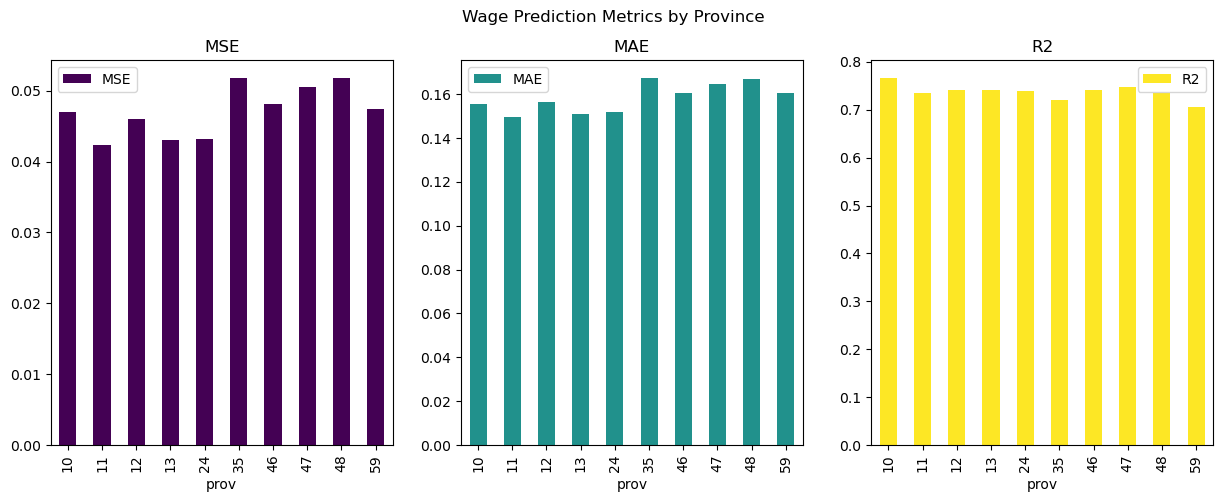

In [27]:
#Provinces
sensitive_features1 = pd.DataFrame({
    "prov": x_test['PROV']      
})

metrics = {
    "MSE": mean_squared_error,
    "MAE": mean_absolute_error,
    "R2": r2_score
}

pr_wage = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_features1
)

pr_wage.by_group.plot(
    kind="bar", 
    subplots=True, 
    layout=[1, 3],     # 1 row, 3 columns for MSE, MAE, R2
    figsize=(15, 5), 
    title="Wage Prediction Metrics by Province",
    colormap="viridis"
)

#### Gender and Education
The model exhibits predictive inequity, as prediction errors (MSE and MAE) are notably higher for men and individuals with high education, showing that its accuracy is not uniform across education and gender groups.

array([[<Axes: title={'center': 'MSE'}, xlabel='gender,Education'>,
        <Axes: title={'center': 'MAE'}, xlabel='gender,Education'>,
        <Axes: title={'center': 'R2'}, xlabel='gender,Education'>]],
      dtype=object)

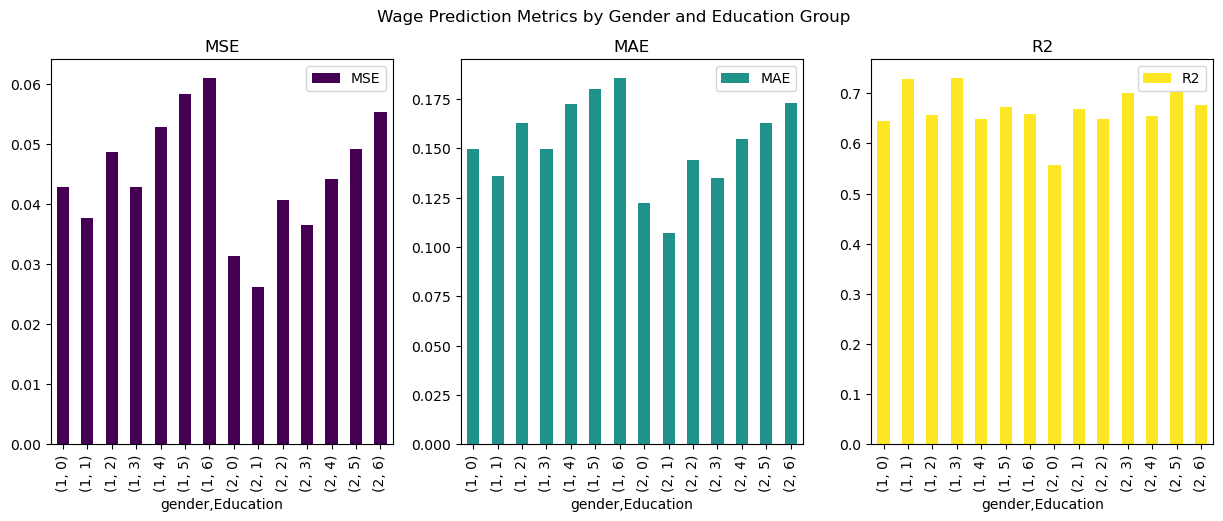

In [29]:
#Gender and education
sensitive_features = pd.DataFrame({
    "gender": x_test['GENDER'],     
    "Education": x_test['EDUC']       
})


metrics = {
    "MSE": mean_squared_error,
    "MAE": mean_absolute_error,
    "R2": r2_score
}


mf_wage = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_features
)

mf_wage.by_group.plot(
    kind="bar", 
    subplots=True, 
    layout=[1, 3],     
    figsize=(15, 5), 
    title="Wage Prediction Metrics by Gender and Education Group",
    colormap="viridis"
)

#### Age
Prediction errors increases progressively and peak for the age group "60 to 64 years"

array([[<Axes: title={'center': 'MSE'}, xlabel='age'>,
        <Axes: title={'center': 'MAE'}, xlabel='age'>,
        <Axes: title={'center': 'R2'}, xlabel='age'>]], dtype=object)

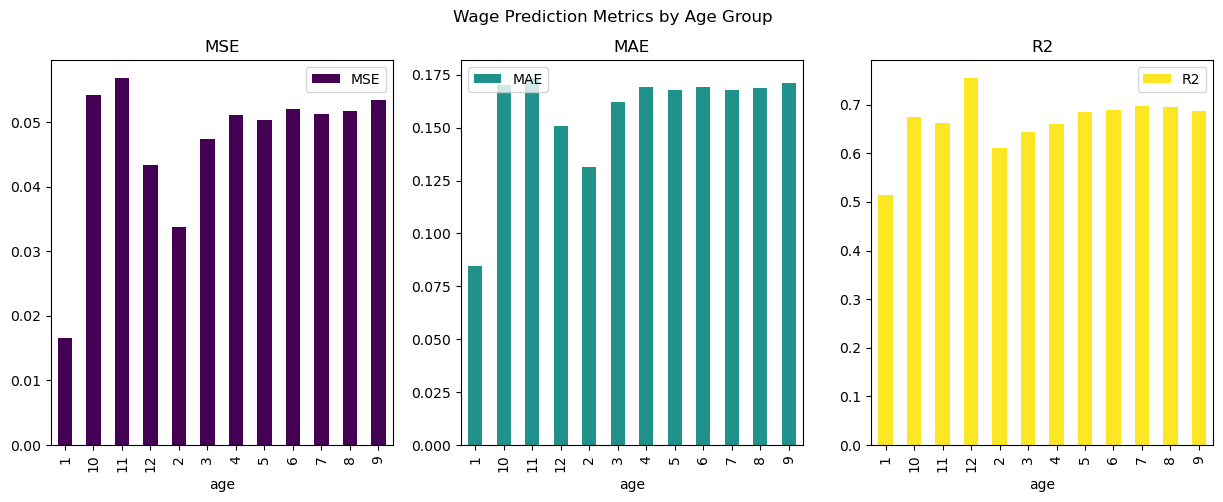

In [30]:
#Age
sensitive_features = pd.DataFrame({
    "age": x_test['AGE_12']       
})


metrics = {
    "MSE": mean_squared_error,
    "MAE": mean_absolute_error,
    "R2": r2_score
}


mf_wage = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_features
)

mf_wage.by_group.plot(
    kind="bar", 
    subplots=True, 
    layout=[1, 3],     
    figsize=(15, 5), 
    title="Wage Prediction Metrics by Age Group",
    colormap="viridis"
)

#### Immigration

The model yields slightly higher prediction errors for immigrants landed more than 10 years earlier compared to non-immigrant and those landed 10 years or less earlier, indicating greater difficulty in capturing wage fluctuations within the landed immigrant workforce.

array([[<Axes: title={'center': 'MSE'}, xlabel='immigration'>,
        <Axes: title={'center': 'MAE'}, xlabel='immigration'>,
        <Axes: title={'center': 'R2'}, xlabel='immigration'>]],
      dtype=object)

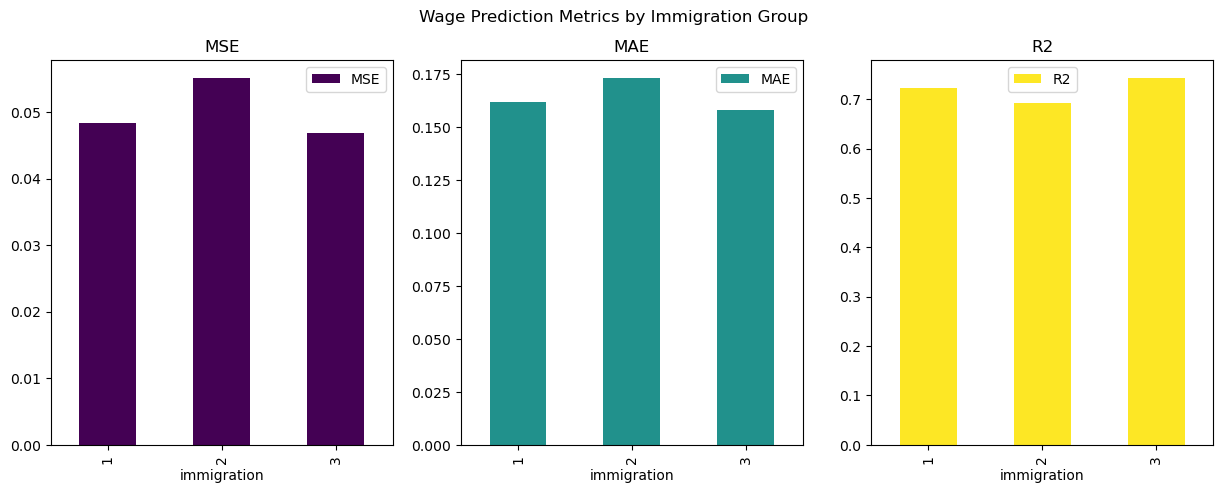

In [32]:
#Immigration
sensitive_features = pd.DataFrame({
    "immigration": x_test['IMMIG']       
})


metrics = {
    "MSE": mean_squared_error,
    "MAE": mean_absolute_error,
    "R2": r2_score
}


mf_wage = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_features
)

mf_wage.by_group.plot(
    kind="bar", 
    subplots=True, 
    layout=[1, 3],     
    figsize=(15, 5), 
    title="Wage Prediction Metrics by Immigration Group",
    colormap="viridis"
)

While the model provides a functional baseline for wage prediction, its inconsistent reliability across demographic segments indicates a need for targeted intervention. To address these systematic accuracy gaps, future phases of this project will focus on ensuring equitable deployment by leveraging Fairlearn’s native toolset to achieve a more uniform predictive precision across all demographic groups.

### Saving the final model

In [33]:
model_simple.save_model('models/model_v1.cbm')